# Comparing time series predictions of COVID-19 deaths


![Comparison](Comparison.png)

In [3]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')


Matplotlib created a temporary config/cache directory at /home/rhyme/.config/matplotlib because the default path (/tmp/matplotlib-9m3s95hd) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
Importing plotly failed. Interactive plots will not work.


# Task 1: Open the data and prepare the dataset data frame

In [4]:
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')

First, get the data for the daily deaths in all countries in the report

In [6]:
d = deaths_df.loc[:,'1/22/20':]
d.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88


Transpose the data frame

In [7]:
d = d.transpose()

Then sum row-wise

In [8]:
d = d.sum(axis=1)

We only need the numeric values here, so we convert `d` to a list

In [9]:
d = d.to_list()

Create a new data frame with two columns, which will be our dataset:

In [12]:
dataset=pd.DataFrame(columns=['ds','y'])

Get the dates from the columns in `deaths_df` data frame, starting from the fifth column. They will be obtained in string format.

In [15]:
dates=list(deaths_df.columns[4:])

Convert the string dates into the datetime format, so that we can perform datetime operations on them

In [16]:
dates=list(pd.to_datetime(dates))

Now, assign the dates and deaths data to the columns in the new dataframe:

In [17]:
dataset['ds']=dates
dataset['y']=d

We will need to have only 1 data column, y, with the index being ds

In [18]:
dataset=dataset.set_index('ds')

Let's plot the daily number of deaths


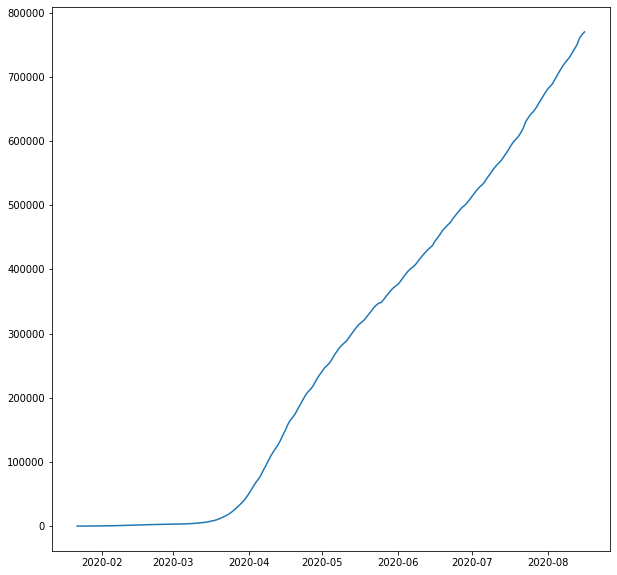

In [20]:
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.savefig('Daily deaths',bbox_inches='tight',transparent='true')

and let's see how the daily increase looks like. To do this, we will use the `diff` method from the Dataframe object.

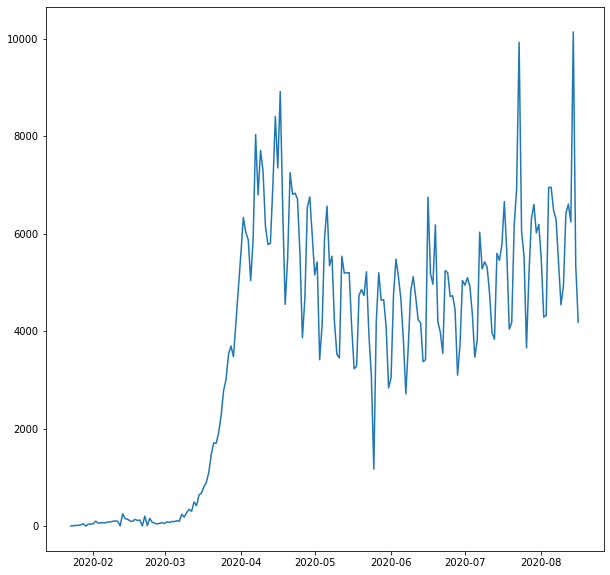

In [21]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig('Daily deaths',bbox_inches='tight',transparent='true')

In this project, we are going to analyze the daily reported deaths

In [22]:
dataset=dataset.diff()

We need to remove the first data point here, which will be a None value

In [23]:
dataset=dataset.loc['2020-01-23':'2020-08-13']

# Task 2: Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

SARIMAX is one of the time series models in the python statistics library statsmodels.

But before we apply the model, we will split our dataset into a training and test sets. We will do this by taking all dates prior to 31st of July as training set, on which the model will be optimized, and all dates from 31st July as the test set, on which we will test the accuracy of the predictions that the optimized model will make.

In [26]:
start_date='2020-07-31'

train=dataset.loc[dataset.index < pd.to_datetime(start_date)]
test=dataset.loc[dataset.index >=pd.to_datetime(start_date)]

Now let's talk about SARIMAX. There are three hyperparameters that go into the order tuple: p, q and d. Here we've used p=2, q=1 and d=3.

In [27]:
model=SARIMAX(train,order=(2,1,3))

Next, we call the fit method to optimize the model.

In [28]:
results = model.fit(disp=True)

Now let's make predictions using the model, and compare those against the values in the test set.

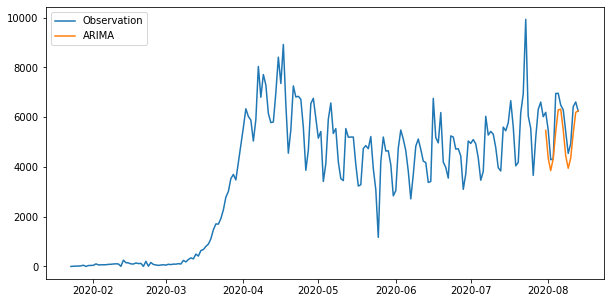

In [29]:
sarimax_prediction = results.predict(
    start=start_date,end='2020-08-13',dynamic=False)
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset,label='Observation')
l2,=plt.plot(sarimax_prediction,label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX prediction',bbox_inches='tight',transparent='True')

Since that we are interested in comparing between the different time series analysis approaches, we are going to use one of the validation measures: mean absolute error.

In [30]:
print('SARIMA MAE =',mean_absolute_error(sarimax_prediction,test))

SARIMA MAE = 650.6157483614192


However, in a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model.


In [31]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.418, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.804, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.295, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.719, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

Note that this gives us the best mode here: "Best model:  SARIMAX(2,2,3)(0,0,0)[0]"

# Task 3: Forcasting using Facebook's Prophet model

This is the open source time series library released by Facebook. It is also widely used by Facebook in their own time series analysis tasks. Facebook prophet does not require that you specify or search for hyperparameters. The model can act as a black box that does all the required computations on its own. And it works with the same object-fit-predict API.

Prophet expects the data frame to have 2 columns, unlike SARIMAX.

In [56]:
train['ds']=train.index.values

Then we create a new Prophet object and call the `fit()` method

In [57]:
m=Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now let's forecast:

In [58]:
future=m.make_future_dataframe(periods=dataset.shape[0]-train.shape[0])
prophet_prediction=m.predict(future)

Now let us calculate the mean absolute error for our predictions.

In [59]:
prophet_prediction=prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index>=start_date]
print('Prophet MAE = ',mean_absolute_error(prophet_future,test))

Prophet MAE =  572.5555342749124


Next, let's visualize the predictions.

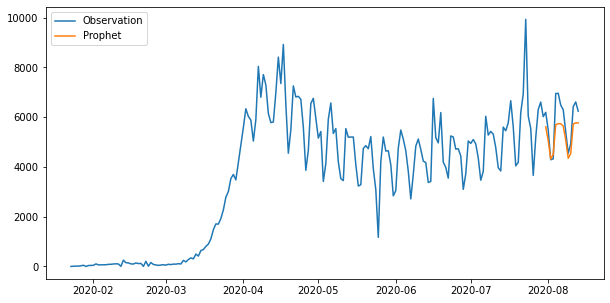

In [60]:
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset,label='Observation')
l2,=plt.plot(prophet_future,label="Prophet")
plt.legend(handles=[l1,l2])
plt.savefig('Prophet predictions',bbox_inches='tight',transparent=False)

# Task 4: Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [62]:
def featurize(t):
    X=pd.DataFrame()
    X['day']=t.index.day
    X['month']=t.index.month
    X['quarter']=t.index.quarter
    X['dayofweek']=t.index.dayofweek
    X['dayofyear']=t.index.dayofyear
    X['weekofyear']=t.index.weekofyear
    y=t.y
    return X, y

featurize(dataset)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,23,1,1,3,23,4
1,24,1,1,4,24,4
2,25,1,1,5,25,4
3,26,1,1,6,26,4
4,27,1,1,0,27,5


# Task 5: Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [63]:
X_train, y_train = featurize(
    dataset.loc[dataset.index < pd.to_datetime(start_date)])
X_test, y_test = featurize(
    dataset.loc[dataset.index >= pd.to_datetime(start_date)])

Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:


In [64]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Apply the scaling to both the training and test sets, as follows.

In [65]:
scaled_train=scaler.transform(X_train)
scaled_test=scaler.transform(X_test)

# Task 6: Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [66]:
XGBOOST_model=XGBRegressor(n_estimators=10)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [67]:
XGBOOST_model.fit(scaled_train,y_train,
                 eval_set=[(scaled_train,y_train),(scaled_test,y_test)],
                 verbose=True)
XGBOOST_prediction=XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:3121.15405	validation_1-rmse:4338.40674
[1]	validation_0-rmse:2264.95044	validation_1-rmse:3135.70386
[2]	validation_0-rmse:1665.83826	validation_1-rmse:2322.55371
[3]	validation_0-rmse:1241.47046	validation_1-rmse:1676.83875
[4]	validation_0-rmse:942.85718	validation_1-rmse:1199.80676
[5]	validation_0-rmse:732.31842	validation_1-rmse:765.99835
[6]	validation_0-rmse:582.53577	validation_1-rmse:501.29828
[7]	validation_0-rmse:472.67627	validation_1-rmse:667.14893
[8]	validation_0-rmse:394.62479	validation_1-rmse:765.89960
[9]	validation_0-rmse:338.00449	validation_1-rmse:1083.99853


Let us calculate the mean absolute error for the training.

In [68]:
print('XGBOOST MAE = ',mean_absolute_error(XGBOOST_prediction,y_test))

XGBOOST MAE =  951.46875


Creation and training of the feedforward neural network model.

In [69]:
NN_model=Sequential()
NN_model.add(Dense(20,input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error',optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train,y_train,validation_data=(
    scaled_test, y_test), epochs=220, verbose=1)
NN_prediction=NN_model.predict(scaled_test)

Epoch 1/220
6/6 [==============================] - 0s 23ms/step - loss: 3521.5266 - val_loss: 5792.9790
Epoch 2/220
6/6 [==============================] - 0s 5ms/step - loss: 3521.4553 - val_loss: 5792.8647
Epoch 3/220
6/6 [==============================] - 0s 6ms/step - loss: 3521.3857 - val_loss: 5792.8125
Epoch 4/220
6/6 [==============================] - 0s 6ms/step - loss: 3521.3171 - val_loss: 5792.7344
Epoch 5/220
6/6 [==============================] - 0s 7ms/step - loss: 3521.2446 - val_loss: 5792.5947
Epoch 6/220
6/6 [==============================] - 0s 8ms/step - loss: 3521.1670 - val_loss: 5792.5166
Epoch 7/220
6/6 [==============================] - 0s 7ms/step - loss: 3521.0845 - val_loss: 5792.4478
Epoch 8/220
6/6 [==============================] - 0s 5ms/step - loss: 3520.9946 - val_loss: 5792.3311
Epoch 9/220
6/6 [==============================] - 0s 6ms/step - loss: 3520.9006 - val_loss: 5792.2544
Epoch 10/220
6/6 [==============================] - 0s 6ms/step - loss: 

Let's compare the MAE values.

In [70]:
print('XGBOOST MAE =', mean_absolute_error(XGBOOST_prediction,y_test))
print('Prophet MAE =', mean_absolute_error(prophet_future,test))
print('SARIMAX MAE =',mean_absolute_error(sarimax_prediction,test))
print('NN MAE =',mean_absolute_error(NN_prediction,test))

XGBOOST MAE = 951.46875
Prophet MAE = 572.5555342749124
SARIMAX MAE = 650.6157483614192
NN MAE = 732.9577985491071


Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

<Figure size 1440x1440 with 0 Axes>

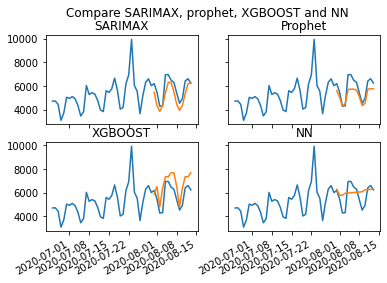

In [71]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)